The task is classify the image i.e. have tumor or not.Then if there is a tumor, segment that part of tumor

# Import Libraries

So first of all we are going to import all the libraries that are required

In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import os
import glob
from skimage import io 

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.python.keras import Sequential 
from tensorflow.keras import optimizers,layers 
from tensorflow.keras.layers import *          
from tensorflow.keras.models import Model       
from tensorflow.keras.initializers import glorot_uniform 
from tensorflow.keras.utils import plot_model   #
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler # The Modules itself signifies the meaning
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Data Preparation

Now we will prepare our dataset

In [2]:
df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
df.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

Let's use our magic function

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
# basic stats
df.describe()

RNASeqCluster  MethylationCluster  miRNACluster   CNCluster  \
count      92.000000          109.000000    110.000000  108.000000   
mean        2.445652            3.678899      1.900000    1.722222   
std         1.180092            1.169684      0.789263    0.862872   
min         1.000000            1.000000      1.000000    1.000000   
25%         1.000000            3.000000      1.000000    1.000000   
50%         2.000000            4.000000      2.000000    1.000000   
75%         4.000000            5.000000      2.000000    3.000000   
max         4.000000            5.000000      4.000000    3.000000   

       RPPACluster  OncosignCluster  COCCluster  histological_type  \
count    98.000000       105.000000  110.000000         109.000000   
mean      2.367347         1.895238    1.763636           2.128440   
std       1.125045         0.663960    0.855927           0.850935   
min       1.000000         1.000000    1.000000           1.000000   
25%       1.000000         1.000000    1.000000           1.000000   
50%       2.000000         2.000000    1.000000           2.000000   
75%       3.000000         2.000000    3.000000           3.000000   
max       4.000000         3.000000    3.000000           3.000000   

       neoplasm_histologic_grade  tumor_tissue_site  laterality  \
count                 109.000000              109.0  109.000000   
mean                    1.532110                1.0    2.009174   
std                     0.501273                0.0    0.995317   
min                     1.000000                1.0    1.000000   
25%                     1.000000                1.0    1.000000   
50%                     2.000000                1.0    2.000000   
75%                     2.000000                1.0    3.000000   
max                     2.000000                1.0    3.000000   

       tumor_location      gender  age_at_initial_pathologic        race  \
count      109.000000  109.000000                 109.000000  108.000000   
mean         3.513761    1.486239                  45.834862    2.907407   
std          1.863960    0.502119                  13.797151    0.291212   
min          1.000000    1.000000                  20.000000    2.000000   
25%          2.000000    1.000000                  34.000000    3.000000   
50%          2.000000    1.000000                  47.000000    3.000000   
75%          6.000000    2.000000                  58.000000    3.000000   
max          6.000000    2.000000                  75.000000    3.000000   

        ethnicity     death01  
count  102.000000  109.000000  
mean     1.970588    0.247706  
std      0.169792    0.433674  
min      1.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    0.000000  
75%      2.000000    0.000000  
max      2.000000    1.000000

Let's make a dataframe which will going to tell us the null count and null % for each feature

In [5]:
null_rate_df = pd.DataFrame(columns=['Column','Count','null_rate'])

null_rate_df['Column'] = [i for i in df.columns]
null_rate_df['Count'] = [j for j in df.isnull().sum()]

# null rate
null_rates = df.isnull().sum()/df.shape[0]*100
null_rate_df['null_rate'] = [k for k in null_rates]

In [6]:
null_rate_df

Column  Count  null_rate
0                     Patient      0   0.000000
1               RNASeqCluster     18  16.363636
2          MethylationCluster      1   0.909091
3                miRNACluster      0   0.000000
4                   CNCluster      2   1.818182
5                 RPPACluster     12  10.909091
6             OncosignCluster      5   4.545455
7                  COCCluster      0   0.000000
8           histological_type      1   0.909091
9   neoplasm_histologic_grade      1   0.909091
10          tumor_tissue_site      1   0.909091
11                 laterality      1   0.909091
12             tumor_location      1   0.909091
13                     gender      1   0.909091
14  age_at_initial_pathologic      1   0.909091
15                       race      2   1.818182
16                  ethnicity      8   7.272727
17                    death01      1   0.909091

In [7]:
data_map = []
# iterate in each of the folder inside the lgg-mri-segmantation/kaggle_3m
for sub_dir_path in glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/'+'*'): 
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):              # iterat in each of the instances
            image_path = sub_dir_path+'/'+filename             # total file path
            data_map.extend([dir_name,image_path])             # Appending the name, image path
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [8]:
data = pd.DataFrame({"patient_id":data_map[::2],'path':data_map[1::2]}) # Creating a final dataframe of name, path
data.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [9]:
# create a dataframe of the path of the images
df_imgs = data[~data['path'].str.contains('mask')]     
# create a dataframe of path of the mask of the image
df_masks = data[data['path'].str.contains('mask')]       
BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN=9

# data Sorting
imgs = sorted(df_imgs['path'].values,key = lambda x: int(x[BASE_LEN:-END_IMG_LEN])) # sorting by last numbers
masks = sorted(df_masks['path'].values,key = lambda x:int(x[BASE_LEN:-END_MASK_LEN])) #similar as above (due to this sorting, we would get a pair of image path, and mask path)

idx = random.randint(0,len(imgs)-1)
print("Path to the image:",imgs[idx],'\nPath to the Mask:',masks[idx])

Path to the image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_17.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_17_mask.tif


**Create a final dataset**

In [10]:
brain_df = pd.DataFrame({'patient_id':df_imgs.patient_id.values,
                    'image_path':imgs,'mask_path':masks})         # create a dataframe containing the id, the image path and the mask path

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))                         # this is for determining whether tumor exists or not
    if value>0:
        return 1
    else:
        return 0
brain_df['mask'] = brain_df['mask_path'].apply(lambda x:pos_neg_diagnosis(x))
brain_df.head()

patient_id                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  mask  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0

# Data Visualization

Let's see how many person have tumor

Text(0.5, 1.0, 'Mask')

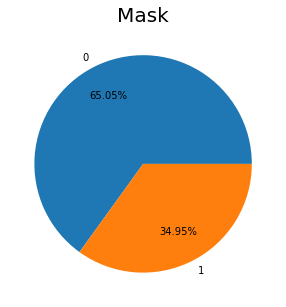

In [11]:
mask = brain_df['mask'].value_counts()
labels = mask.keys()
bar,ax = plt.subplots(figsize=(5,5))
plt.pie(x = mask, labels = labels, autopct="%.2f%%",pctdistance=0.7)
plt.title('Mask', fontsize=20)

So 65.05% do not have tumor and 35.95% have tumor.Let's see the tumor image now

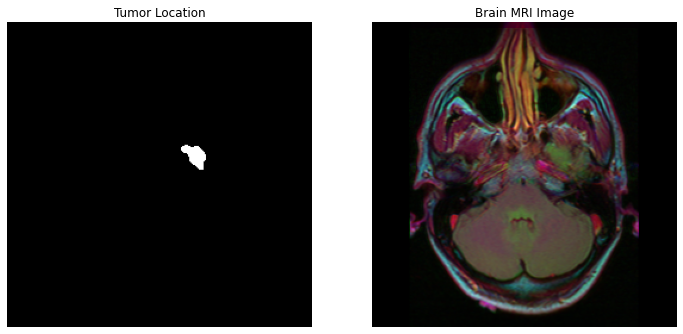

In [12]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df['mask_path'][i]).max()>0:
        break

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(cv2.imread(brain_df['mask_path'][i]));
plt.title('Tumor Location')
plt.axis('off')
plt.subplot(122)
plt.imshow(cv2.imread(brain_df['image_path'][i]));
plt.title("Brain MRI Image")
plt.axis('off')
plt.show()

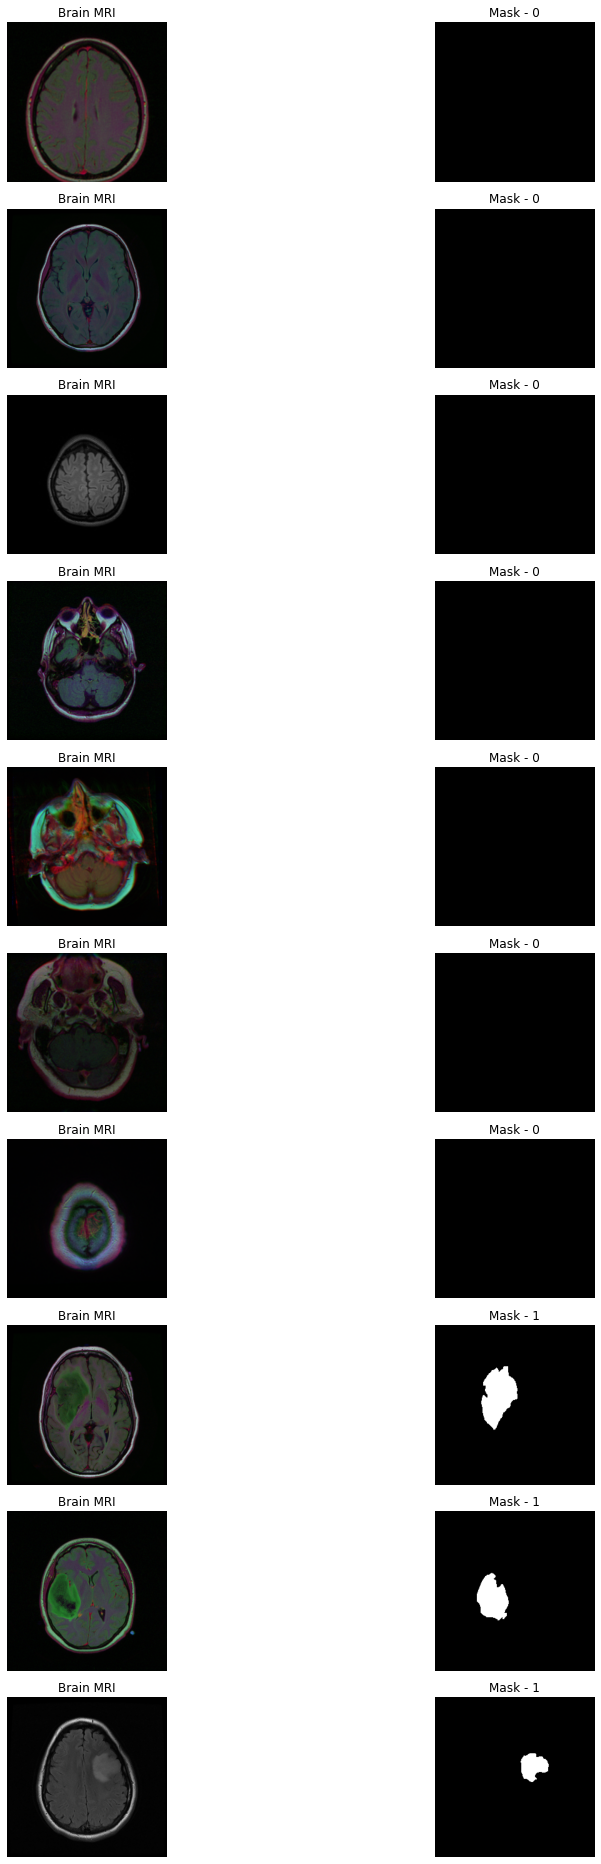

In [13]:
fig,axs = plt.subplots(10,2,figsize=(16,26))
count = 0
for x in range(10):
    i = random.randint(0,len(brain_df))
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(cv2.imread(brain_df['image_path'][i]))
    axs[count][1].title.set_text("Mask - "+str(brain_df['mask'][i]))
    axs[count][1].imshow(cv2.imread(brain_df['mask_path'][i]))
    axs[count][0].axis('off')
    axs[count][1].axis('off')
    count+=1
fig.tight_layout()

Now let's plot images with mask

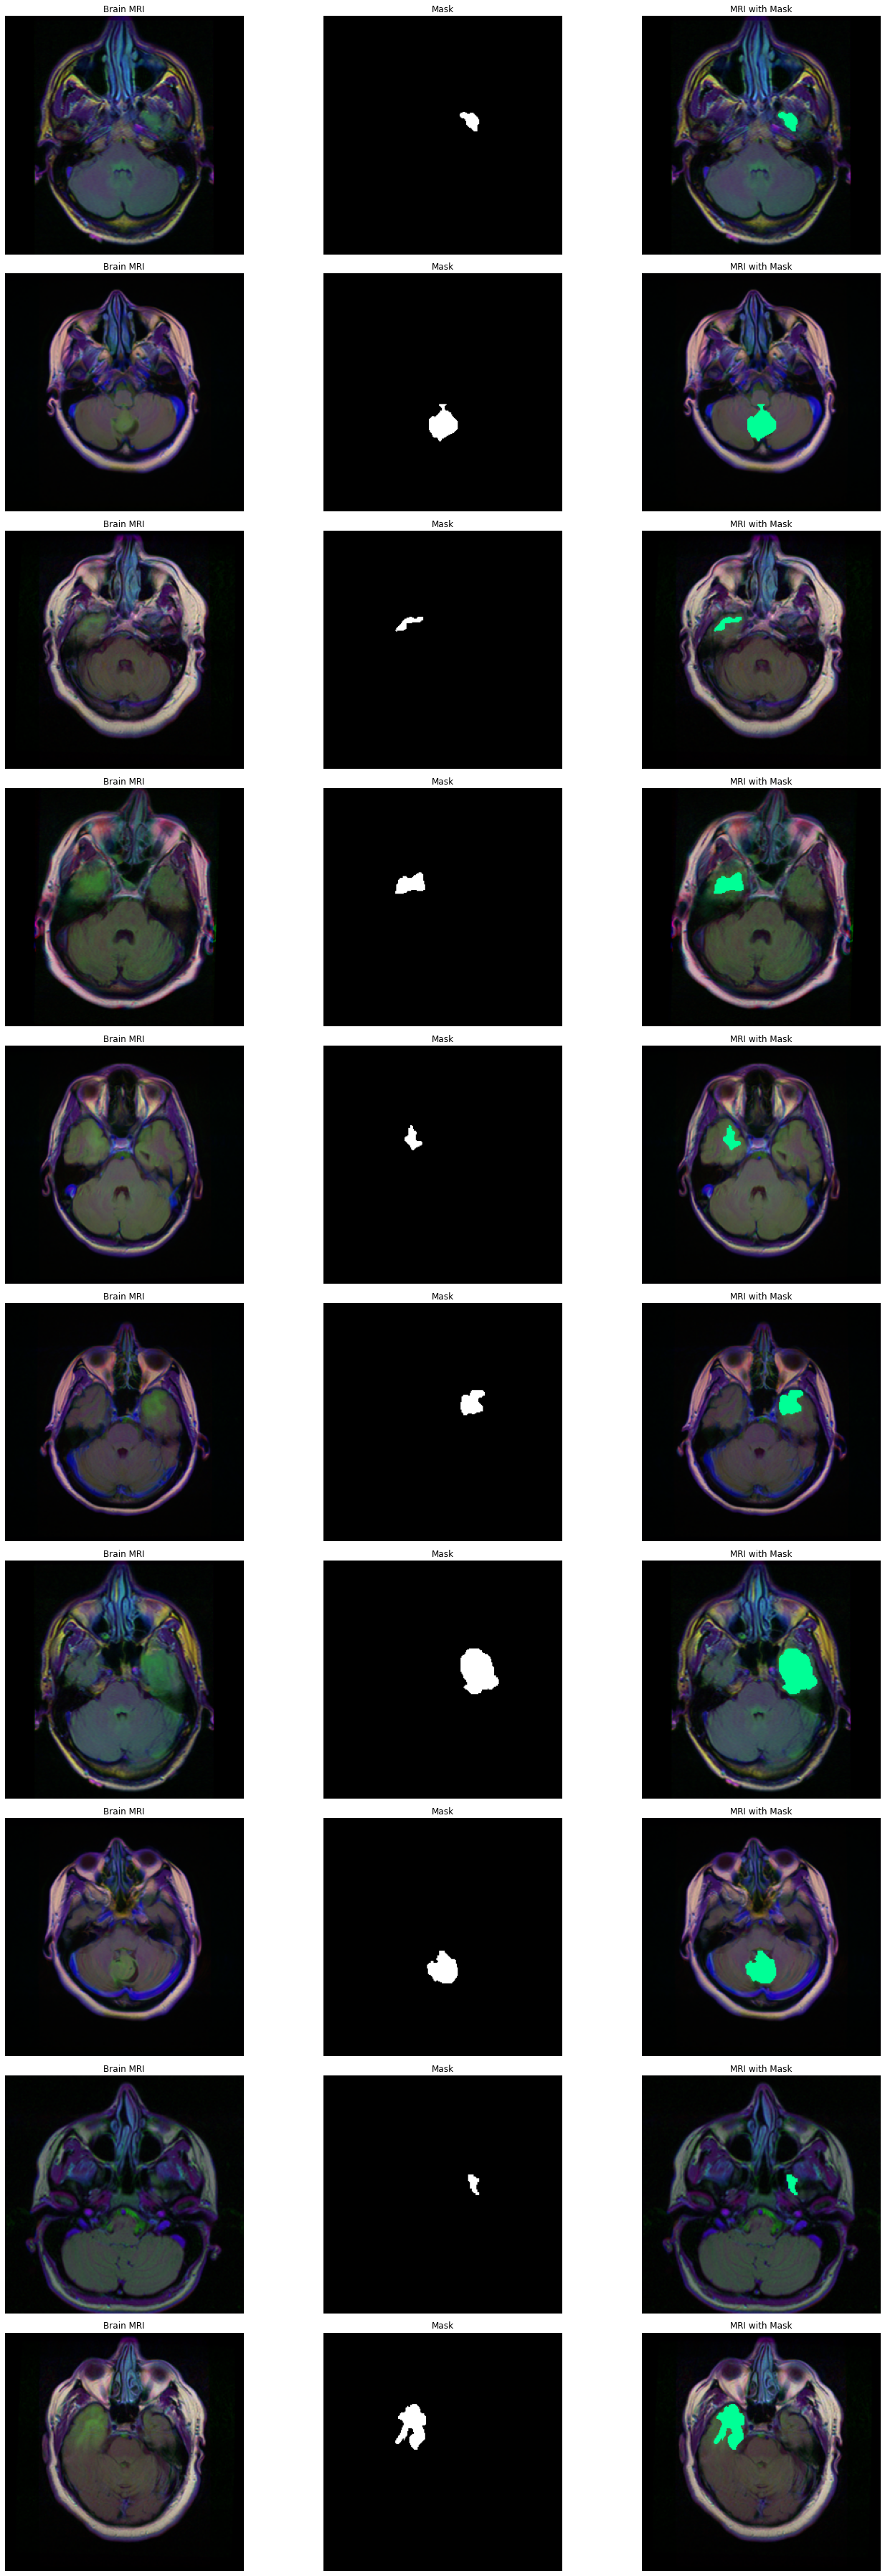

In [14]:
count = 0
i = 0
fig,axs= plt.subplots(10,3,figsize=(20,50))
for mask in brain_df['mask']:
    if(mask==1):
        img = io.imread(brain_df['image_path'][i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df['mask_path'][i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask,cmap ='gray')
        img[mask==255]=(0,255,150)
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        axs[count][0].axis('off')
        axs[count][1].axis('off')
        axs[count][2].axis('off')
        count+=1
    i+=1
    if(count==10):
        break
fig.tight_layout()

# Split dataset into train, test and validation 

Now , we will create the dataset, so that it could be directly fed into the model 

In [15]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.head(2)

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path mask  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0

In [16]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [17]:
train,test = train_test_split(brain_df_train,test_size=0.15) 

In [18]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
# Creating dataset
train_generator = datagen.flow_from_dataframe(train,directory = './',
                x_col = 'image_path',y_col='mask',subset='training',class_mode='categorical',
                                             batch_size=16,shuffle=True,target_size=(256,256))
valid_generator = datagen.flow_from_dataframe(train,directory='./',
                                x_col = 'image_path',y_col = 'mask',
                                             subset='validation',class_mode='categorical',batch_size=16,shuffle=True,target_size=(256,256))
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test,directory='./',x_col='image_path',y_col = 'mask',class_mode='categorical',batch_size=16,shuffle=False,target_size=(256,256))

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# Create and Train Model

We will use ResNet50

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet',include_top=False,input_tensor = Input(shape=(256,256,3)))
clf_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [20]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256,activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256,activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2,activation='softmax')(head)

model = Model(clf_model.input,head)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Let'suse early stopping, so that our model won't overfit

In [21]:
early_stopping= EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5) 
check_pointer = ModelCheckpoint(filepath = 'clf-resnet-checkpoint.hdf5',verbose=1,save_best_only=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=5,min_delta = 0.0001,factor=0.2) 
callbacks = [check_pointer,early_stopping,reduce_lr]

In [22]:
h = model.fit(train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                        epochs=30,validation_data=valid_generator,validation_steps = valid_generator.n//valid_generator.batch_size,
                             callbacks = [check_pointer,early_stopping])

Epoch 1/30
187/187 [==============================] - 40s 161ms/step - loss: 1.0689 - accuracy: 0.6930 - val_loss: 1.4253 - val_accuracy: 0.6219

Epoch 00001: val_loss improved from inf to 1.42528, saving model to clf-resnet-checkpoint.hdf5
Epoch 2/30
187/187 [==============================] - 25s 135ms/step - loss: 0.4416 - accuracy: 0.7973 - val_loss: 8.4293 - val_accuracy: 0.6219

Epoch 00002: val_loss did not improve from 1.42528
Epoch 3/30
187/187 [==============================] - 25s 135ms/step - loss: 0.3352 - accuracy: 0.8631 - val_loss: 7.0242 - val_accuracy: 0.6250

Epoch 00003: val_loss did not improve from 1.42528
Epoch 4/30
187/187 [==============================] - 25s 135ms/step - loss: 0.3639 - accuracy: 0.8189 - val_loss: 4.9927 - val_accuracy: 0.6156

Epoch 00004: val_loss did not improve from 1.42528
Epoch 5/30
187/187 [==============================] - 25s 135ms/step - loss: 0.2391 - accuracy: 0.9129 - val_loss: 1.6495 - val_accuracy: 0.7000

Epoch 00005: val_loss 

In [23]:
# Saving the Model architecture in json file
model_json = model.to_json()
with open('clf-resnet.json','w') as json_file:
    json_file.write(model_json)
model.save('clf-brain.hdf5')

# EVALUATION

h.history.keys()

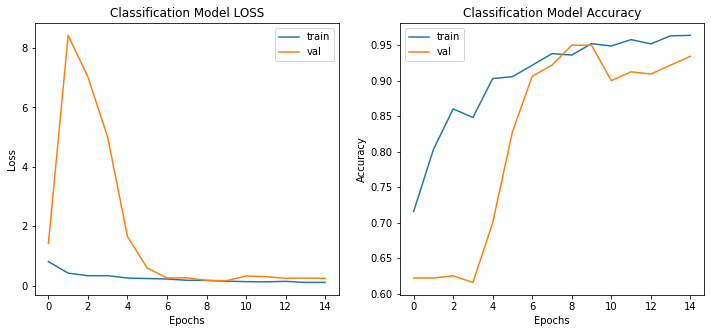

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title("Classification Model LOSS")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train','val'])

plt.subplot(122)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title("Classification Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(['train','val'])
plt.show()

In [25]:
_,acc = model.evaluate(test_generator)
print("Test Accuracy :  {} %".format(acc*100))

37/37 [==============================] - 6s 161ms/step - loss: 0.2465 - accuracy: 0.9390
Test Accuracy :  93.89830231666565 %


0.9389830508474576
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       392
           1       0.96      0.86      0.90       198

    accuracy                           0.94       590
   macro avg       0.94      0.92      0.93       590
weighted avg       0.94      0.94      0.94       590



<AxesSubplot:>

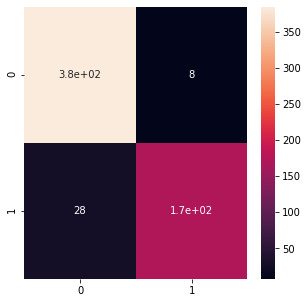

In [26]:
prediction = model.predict(test_generator)
pred = np.argmax(prediction,axis=1)
original = np.asarray(test['mask']).astype('int')


accuracy = accuracy_score(original,pred)
print(accuracy)

cm = confusion_matrix(original,pred)
report = classification_report(original,pred,labels=[0,1])
print(report)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)

# Segmentation Model to localize Tumor

So our classification task isdone, now we are going to work on segment part

In [27]:
brain_df_mask = brain_df[brain_df['mask']==1]
brain_df_mask.shape

(1373, 4)

Now split the dataset into training and validation 

In [28]:
X_train,X_val = train_test_split(brain_df_mask,test_size=0.15)
X_test,X_val = train_test_split(X_val,test_size=0.5)

print("Train Size is {}, validation size is {} & test size is {}".format(len(X_train),len(X_val),len(X_test)))
      
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
      
val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

Train Size is 1167, validation size is 103 & test size is 103


# Custom Data Generator

In [29]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y
  def on_epoch_end(self):

    #get the ImageId corresponding to the indexes created above based on batch size
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

# Create a ResUnet Block

In [30]:
def resblock(X,f):
    X_copy = X
    X  =Conv2D(f,kernel_size=(1,1),kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f,kernel_size=(3,3),padding='same',kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    X_copy = Conv2D(f,kernel_size=(1,1),kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    X = Add()([X,X_copy])
    X =Activation('relu')(X)
    
    return X

def upsample_concat(x,skip):
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X,skip])
    return merge

In [31]:
input_shape = (256,256,3)
X_input = Input(input_shape)

# Stage 1
conv_1 = Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(X_input)
conv_1 =BatchNormalization()(conv_1)
conv_1 = Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# Stage 2
conv_2 = resblock(pool_1,32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2,64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3,128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4,256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5,conv_4)
up_1 = resblock(up_1,128)

# Upsample Stage 2
up_2 = upsample_concat(up_1,conv_3)
up_2 = resblock(up_2,64)

# Upsample Stage 3
up_3 = upsample_concat(up_2,conv_2)
up_3 = resblock(up_3,32)

# Upsample stage 4
up_4 = upsample_concat(up_3,conv_1)
up_4 = resblock(up_4,16)

out = Conv2D(1,(1,1),kernel_initializer='he_normal',padding='same',activation='sigmoid')(up_4)
seg_model = Model(X_input,out)
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

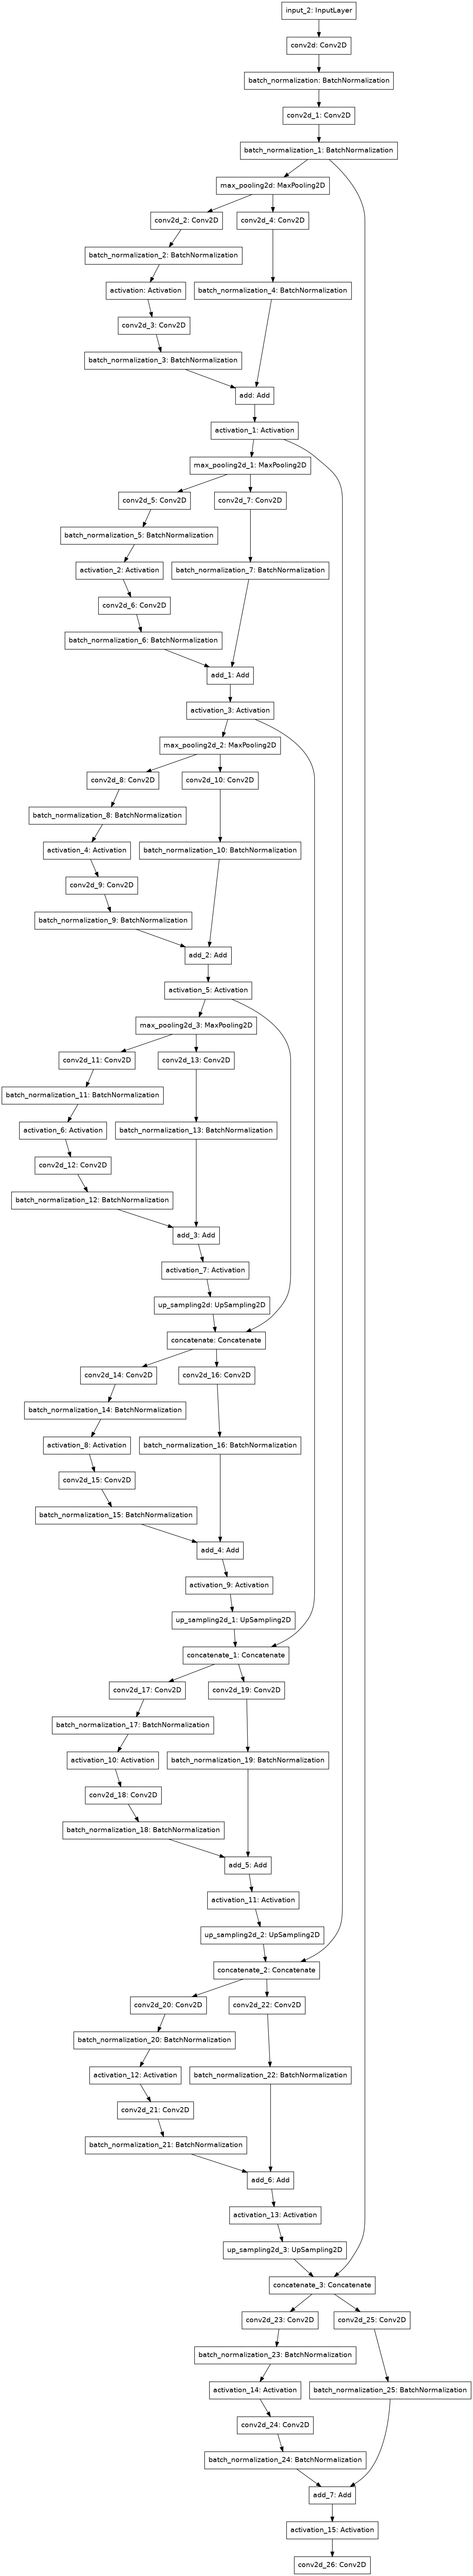

In [32]:
tf.keras.utils.plot_model(seg_model,to_file='seg_model.png')

# Train Model

In [33]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''

from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [34]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=5
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="seg-ResUNet-checkpoint.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [35]:
h = seg_model.fit(train_data,epochs = 30,validation_data = val_data,callbacks=[checkpointer,early_stopping,reduce_lr])

Epoch 1/30
72/72 [==============================] - 14s 145ms/step - loss: 0.8884 - tversky: 0.1456 - val_loss: 0.7871 - val_tversky: 0.2731

Epoch 00001: val_loss improved from inf to 0.78714, saving model to seg-ResUNet-checkpoint.hdf5
Epoch 2/30
72/72 [==============================] - 10s 135ms/step - loss: 0.6818 - tversky: 0.3963 - val_loss: 0.6809 - val_tversky: 0.4002

Epoch 00002: val_loss improved from 0.78714 to 0.68094, saving model to seg-ResUNet-checkpoint.hdf5
Epoch 3/30
72/72 [==============================] - 10s 135ms/step - loss: 0.4187 - tversky: 0.6844 - val_loss: 0.6011 - val_tversky: 0.4922

Epoch 00003: val_loss improved from 0.68094 to 0.60110, saving model to seg-ResUNet-checkpoint.hdf5
Epoch 4/30
72/72 [==============================] - 9s 130ms/step - loss: 0.3415 - tversky: 0.7602 - val_loss: 0.6375 - val_tversky: 0.4496

Epoch 00004: val_loss did not improve from 0.60110
Epoch 5/30
72/72 [==============================] - 10s 134ms/step - loss: 0.3242 - tv

In [36]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("seg-ResUNet.json", "w") as json_file:
    json_file.write(seg_model_json)
seg_model.save('seg_brain.hdf5')

# Segment Model Evaluation

In [37]:
h.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

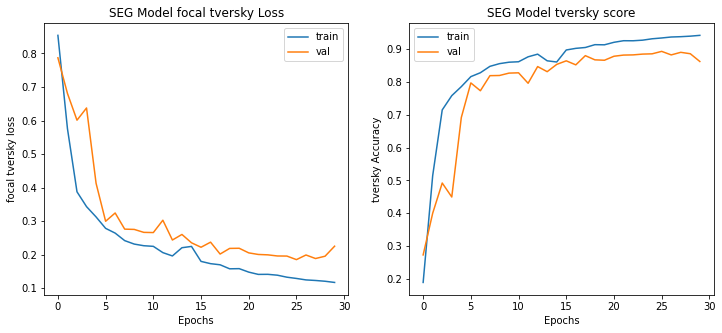

In [38]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [39]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 94ms/step - loss: 0.2124 - tversky: 0.8720
Segmentation tversky is 87.20%


# Prediction

In [40]:
def prediction(test,model,model_seg):
    mask,image_id,has_mask = [],[],[]
    
    for i in test.image_path:
        img = io.imread(i)
        img=img*1./255.0
        img = cv2.resize(img,(256,256))
        img = np.array(img,dtype=np.float64)
        img = np.reshape(img,(1,256,256,3))
        
        is_defect = model.predict(img)
        
        if np.argmax(is_defect) ==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append("No Mask :)")
            continue
        
        X = np.empty((1,256,256,3))
        img = io.imread(i)
        img = cv2.resize(img,(256,256))
        img = np.array(img,dtype=np.float64)
        img-=img.mean()
        img/=img.std()
        X[0,] = img
        predict = model_seg.predict(X)
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append("No Mask :)")
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
    return pd.DataFrame({"image_path":image_id,'predicted_mask':mask,'has_mask':has_mask})

In [41]:
df_pred = prediction(test,model,seg_model)
df_pred

image_path  \
0    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
..                                                 ...   
585  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
586  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
587  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
588  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
589  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                        predicted_mask  has_mask  
0                                           No Mask :)         0  
1    [[[[2.7102883e-06], [1.2355577e-05], [1.256007...         1  
2                                           No Mask :)         0  
3    [[[[2.1328624e-06], [1.4136469e-05], [1.748909...         1  
4                                           No Mask :)         0  
..                                                 ...       ...  
585                                         No Mask :)         0  
586                                         No Mask :)         0  
587  [[[[2.6227915e-06], [1.3766453e-05], [1.809487...         1  
588                                         No Mask :)         0  
589                                         No Mask :)         0  

[590 rows x 3 columns]

In [42]:
df_pred = test.merge(df_pred,on='image_path')
df_pred.head(10)

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path mask  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    1   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...    0   

                                      predicted_mask  has_mask  
0                                         No Mask :)         0  
1  [[[[2.7102883e-06], [1.2355577e-05], [1.256007...         1  
2                                         No Mask :)         0  
3  [[[[2.1328624e-06], [1.4136469e-05], [1.748909...         1  
4                                         No Mask :)         0  
5  [[[[2.7734868e-06], [1.5083856e-05], [1.790693...         1  
6                                         No Mask :)         0  
7                                         No Mask :)         0  
8  [[[[1.6105058e-06], [7.635897e-06], [1.6360565...         1  
9                                         No Mask :)         0

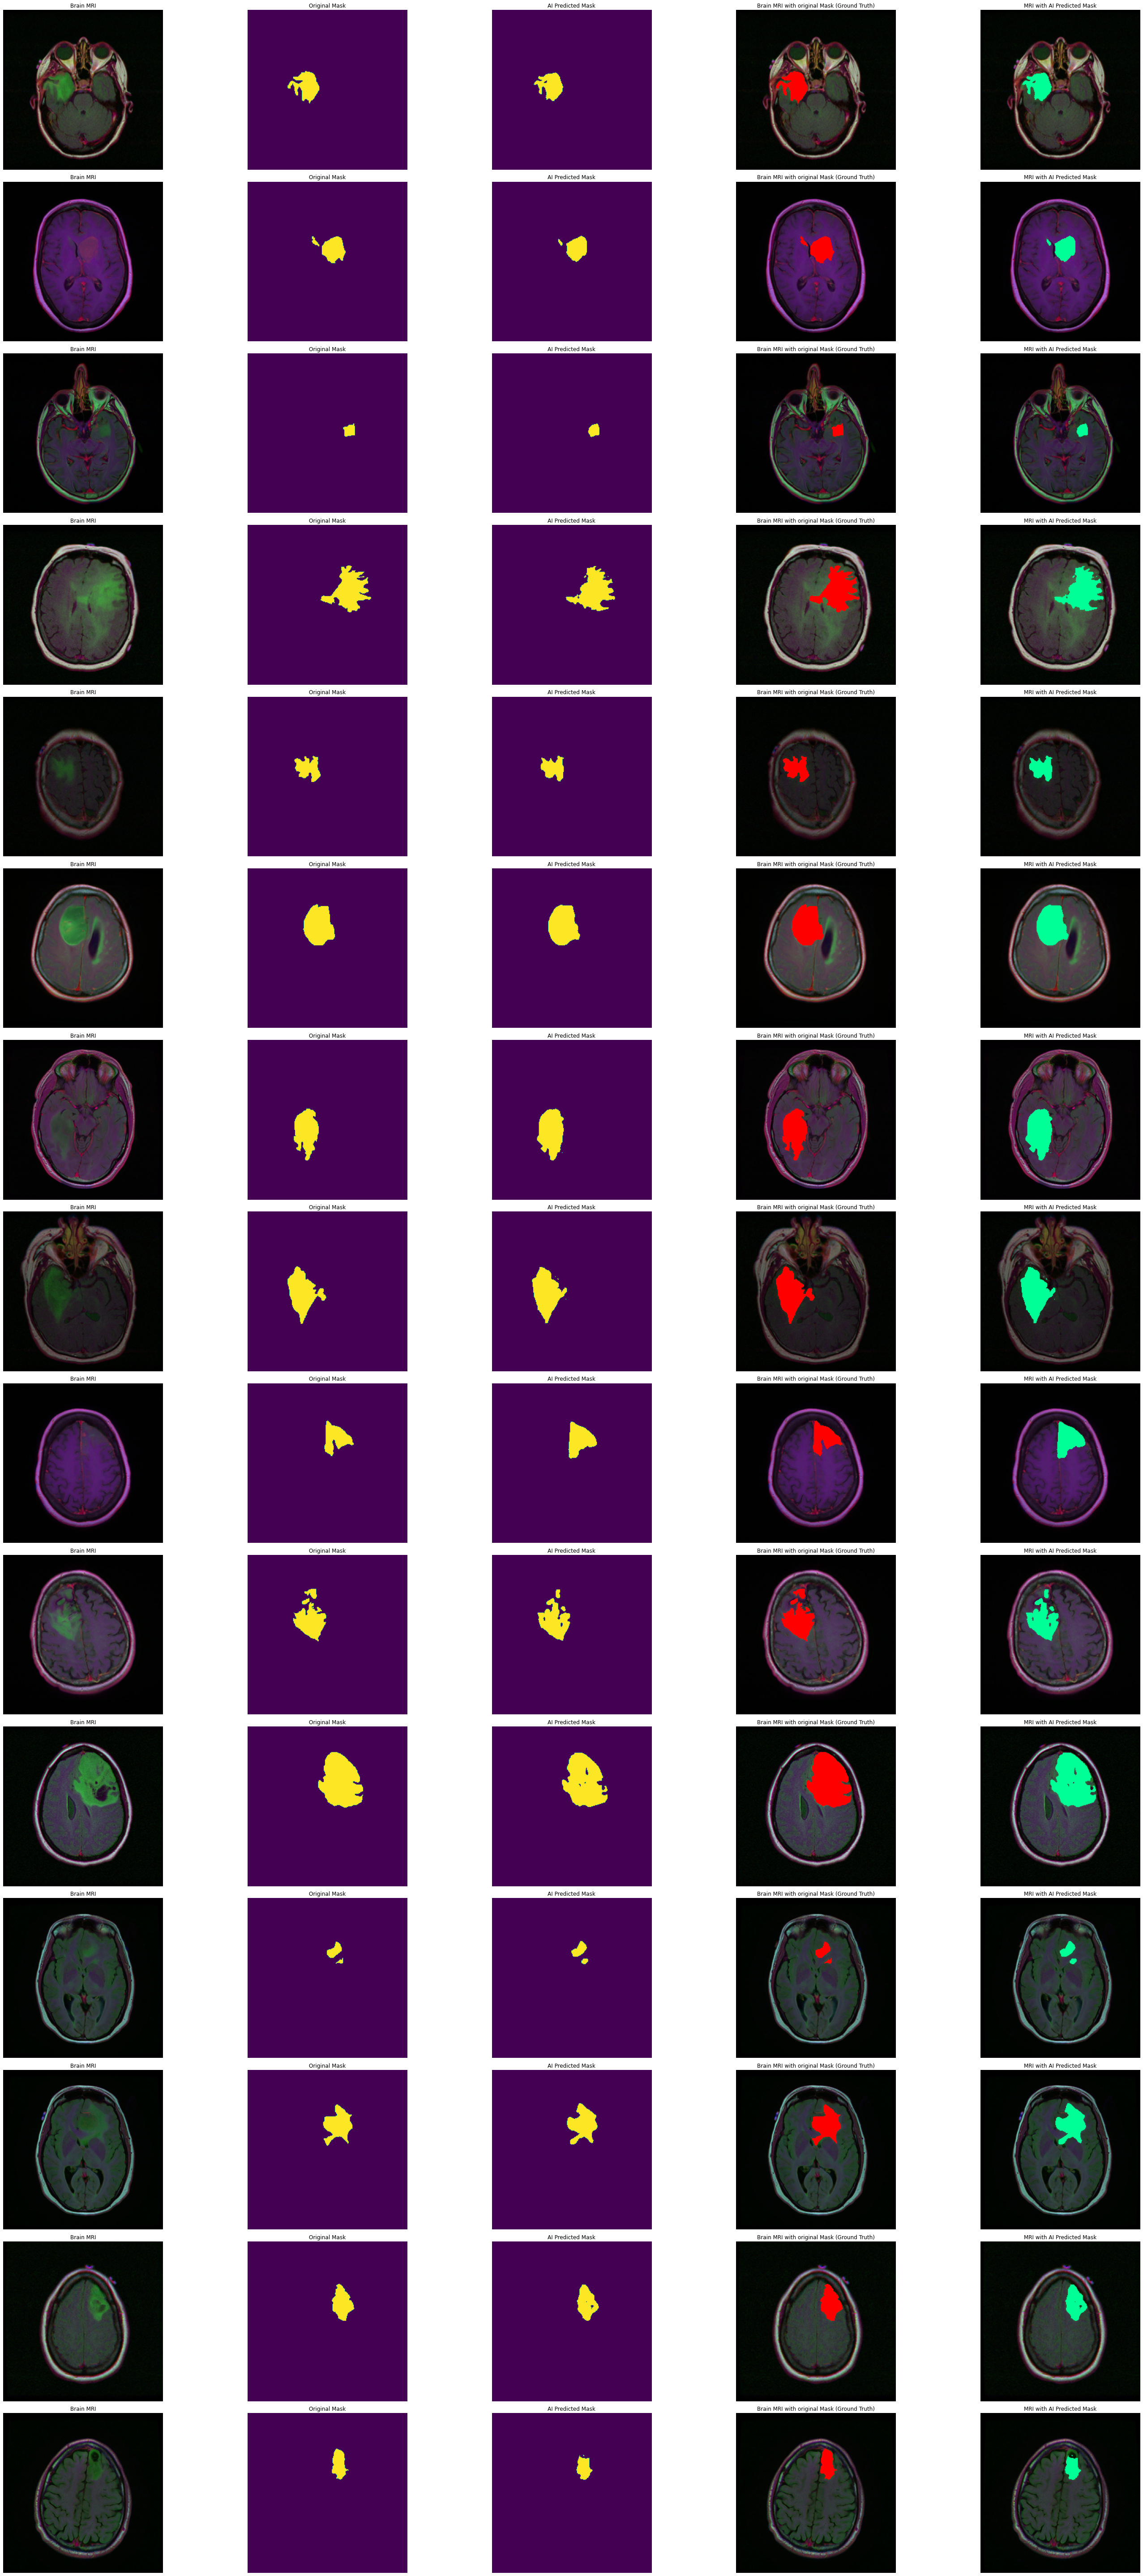

In [43]:
count = 0
fig,axs = plt.subplots(15,5,figsize=(40,80))
for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].axis('off')
        
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text("Original Mask")
        axs[count][1].axis('off')
        
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text("AI Predicted Mask")
        axs[count][2].axis('off')
        
        img[mask==255] =(255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text("Brain MRI with original Mask (Ground Truth)")
        axs[count][3].axis('off')
        
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
        img_[pred==1]= (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text("MRI with AI Predicted Mask")
        axs[count][4].axis('off')
        count+=1
    if(count==15):
        break
fig.tight_layout()